# **AIRTELLIGENCE**

# **Stock price prediction using combined GARCH-AI models**

In [ ]:
#1776 days with holidays and weekends

import yfinance as yf
import pandas as pd

# Download Airtel Africa stock data (London Stock Exchange ticker: AAF.L)
data = yf.download("AAF.L", start="2019-06-28", end="2024-05-08")

# Create full daily date range
full_range = pd.date_range(start="2019-06-28", end="2024-05-08", freq="D")

# Reindex data to daily frequency (missing days will show NaN)
data = data.reindex(full_range)

print(data.head(10))
print(data.tail(10))

# Save to CSV
data.to_csv("airtel_africa_daily.csv")

/tmp/ipython-input-3468288976.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAF.L", start="2019-06-28", end="2024-05-08")
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open      Volume
Ticker          AAF.L      AAF.L      AAF.L      AAF.L       AAF.L
2019-06-28  67.609016  76.783098  66.811267  76.783098  64367704.0
2019-06-29        NaN        NaN        NaN        NaN         NaN
2019-06-30        NaN        NaN        NaN        NaN         NaN
2019-07-01  70.799988  74.160497  67.858301  67.858301  16286773.0
2019-07-02  71.797195  72.295787  71.797195  71.916860   3565649.0
2019-07-03  71.896904  72.794370  71.827101  72.794370   6511595.0
2019-07-04  72.196068  72.914041  72.056463  72.914041    269558.0
2019-07-05  73.093521  73.791546  72.196055  72.225969   3240264.0
2019-07-06        NaN        NaN        NaN        NaN         NaN
2019-07-07        NaN        NaN        NaN        NaN         NaN
Price            Close        High         Low        Open     Volume
Ticker           AAF.L       AAF.L       AAF.L       AAF.L      AAF.L
2024-04-29  112.032440  112.032440  109.733831  109.7338

#**Data Pre-Processing**

In [ ]:
# Apply forward fill to the data
data = data.ffill()

# Print the head and tail to verify
print(data.head(10))
print(data.tail(10))

Price           Close       High        Low       Open      Volume
Ticker          AAF.L      AAF.L      AAF.L      AAF.L       AAF.L
2019-06-28  67.609016  76.783098  66.811267  76.783098  64367704.0
2019-06-29  67.609016  76.783098  66.811267  76.783098  64367704.0
2019-06-30  67.609016  76.783098  66.811267  76.783098  64367704.0
2019-07-01  70.799988  74.160497  67.858301  67.858301  16286773.0
2019-07-02  71.797195  72.295787  71.797195  71.916860   3565649.0
2019-07-03  71.896904  72.794370  71.827101  72.794370   6511595.0
2019-07-04  72.196068  72.914041  72.056463  72.914041    269558.0
2019-07-05  73.093521  73.791546  72.196055  72.225969   3240264.0
2019-07-06  73.093521  73.791546  72.196055  72.225969   3240264.0
2019-07-07  73.093521  73.791546  72.196055  72.225969   3240264.0
Price            Close        High         Low        Open     Volume
Ticker           AAF.L       AAF.L       AAF.L       AAF.L      AAF.L
2024-04-29  112.032440  112.032440  109.733831  109.7338

# **LSTM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Copy clean dataset
data_lstm = data.copy()

In [ ]:
# Compute log returns (optional, as per paper)

# Inspect the columns of data_lstm to understand the correct way to access 'Close'
print(data_lstm.columns)

# Correctly access the 'Close' column using the MultiIndex ('Close', 'AAF.L')
data_lstm['LogRet'] = np.log(data_lstm[('Close', 'AAF.L')]).diff()

# Drop initial NA and the first LogRet NA, accessing 'Close' and 'LogRet' with their MultiIndex keys
data_lstm = data_lstm.dropna(subset=[('Close', 'AAF.L'), ('LogRet', '')])

MultiIndex([( 'Close', 'AAF.L'),
            (  'High', 'AAF.L'),
            (   'Low', 'AAF.L'),
            (  'Open', 'AAF.L'),
            ('Volume', 'AAF.L')],
           names=['Price', 'Ticker'])


In [ ]:
# 67% train, 33% test

n = len(data_lstm)
train_size = int(n * 0.67)

train_lstm = data_lstm.iloc[:train_size]
test_lstm = data_lstm.iloc[train_size:]


In [ ]:
#scaling

scaler_lstm = MinMaxScaler()

train_scaled_lstm = scaler_lstm.fit_transform(train_lstm[['Close']])
test_scaled_lstm  = scaler_lstm.transform(test_lstm[['Close']])


In [ ]:
#create sequences

lookback = 60

def make_sequences(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = make_sequences(train_scaled_lstm, lookback)
X_test_lstm, y_test_lstm = make_sequences(test_scaled_lstm, lookback)

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], lookback, 1)
X_test_lstm  = X_test_lstm.reshape(X_test_lstm.shape[0], lookback, 1)


In [ ]:
#build lstm model

model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(lookback, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss='mean_squared_logarithmic_error')

es = EarlyStopping(patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(patience=3, factor=0.5)

history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.2,
                              callbacks=[es, rlr],
                              verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0653 - val_loss: 0.0142 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0038 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0026 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - val_loss: 9.9313e-04 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0021 - val_loss: 9.9889e-04 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0019 - val_loss: 9.1946e-04 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0017 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 5.0000e-05
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0016 - val_los

In [ ]:
#predictions

y_pred_scaled_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform
dummy = np.zeros((len(y_pred_scaled_lstm), 1))
dummy[:, 0] = y_pred_scaled_lstm.ravel()
y_pred_lstm = scaler_lstm.inverse_transform(dummy)[:, 0]

dummy[:, 0] = y_test_lstm
y_true_lstm = scaler_lstm.inverse_transform(dummy)[:, 0]


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [ ]:
#evaluation

# Calculate Mean Squared Error (MSE) first
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
# Then take the square root to get RMSE
rmse_lstm = np.sqrt(mse_lstm)

mae_lstm  = mean_absolute_error(y_true_lstm, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_true_lstm - y_pred_lstm) / y_true_lstm)) * 100
r2_lstm   = r2_score(y_true_lstm, y_pred_lstm)

print(f"LSTM Results:")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE:  {mae_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}%")
print(f"R²:   {r2_lstm:.4f}")

LSTM Results:
RMSE: 6.0530
MAE:  4.7573
MAPE: 4.17%
R²:   0.5400


# **GRU**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Copy clean dataset for GRU
data_gru = data.copy()


In [ ]:
# Inspect columns
print(data_gru.columns)

# If MultiIndex, flatten it (only once)
if isinstance(data_gru.columns, pd.MultiIndex):
    data_gru.columns = data_gru.columns.get_level_values(0)

# Create log returns (optional, same as LSTM)
data_gru['LogRet'] = np.log(data_gru['Close']).diff()

# Drop NA
data_gru = data_gru.dropna(subset=['Close', 'LogRet'])


MultiIndex([( 'Close', 'AAF.L'),
            (  'High', 'AAF.L'),
            (   'Low', 'AAF.L'),
            (  'Open', 'AAF.L'),
            ('Volume', 'AAF.L')],
           names=['Price', 'Ticker'])


In [ ]:
# 67% train, 33% test

n = len(data_gru)
train_size = int(n * 0.67)

train_gru = data_gru.iloc[:train_size]
test_gru  = data_gru.iloc[train_size:]


In [ ]:
#scaling

scaler_gru = MinMaxScaler()

train_scaled_gru = scaler_gru.fit_transform(train_gru[['Close']])
test_scaled_gru  = scaler_gru.transform(test_gru[['Close']])


In [ ]:
#creating sequence

lookback = 60

def make_sequences(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train_gru, y_train_gru = make_sequences(train_scaled_gru, lookback)
X_test_gru, y_test_gru   = make_sequences(test_scaled_gru, lookback)

# Reshape for GRU [samples, timesteps, features]
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0], lookback, 1)
X_test_gru  = X_test_gru.reshape(X_test_gru.shape[0], lookback, 1)


In [ ]:
#build gru model

model_gru = Sequential()
model_gru.add(GRU(128, return_sequences=True, input_shape=(lookback, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(64))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1))

model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error')   # MSE is safer than MSLE for stock prices

es = EarlyStopping(patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(patience=3, factor=0.5)

history_gru = model_gru.fit(X_train_gru, y_train_gru,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[es, rlr],
                            verbose=1)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0428 - val_loss: 0.0051 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0045 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0033 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0024 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0019 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0023 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0020 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0016 - val_loss: 0.0011 - learning_rate:

In [ ]:
#predictions

y_pred_scaled_gru = model_gru.predict(X_test_gru)

# Inverse transform
dummy = np.zeros((len(y_pred_scaled_gru), 1))
dummy[:, 0] = y_pred_scaled_gru.ravel()
y_pred_gru = scaler_gru.inverse_transform(dummy)[:, 0]

dummy[:, 0] = y_test_gru
y_true_gru = scaler_gru.inverse_transform(dummy)[:, 0]


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
#evaluation

mse_gru  = mean_squared_error(y_true_gru, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru  = mean_absolute_error(y_true_gru, y_pred_gru)
mape_gru = np.mean(np.abs((y_true_gru - y_pred_gru) / y_true_gru)) * 100
r2_gru   = r2_score(y_true_gru, y_pred_gru)

print(f"GRU Results:")
print(f"RMSE: {rmse_gru:.4f}")
print(f"MAE:  {mae_gru:.4f}")
print(f"MAPE: {mape_gru:.2f}%")
print(f"R²:   {r2_gru:.4f}")


GRU Results:
RMSE: 3.0908
MAE:  2.3077
MAPE: 2.02%
R²:   0.8801


# **TRANSFORMER**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# deterministic seed
np.random.seed(42)
tf.random.set_seed(42)

# master copy
data_tf = data.copy()




In [ ]:
if isinstance(data_tf.columns, pd.MultiIndex):
    data_tf.columns = data_tf.columns.get_level_values(0)

data_tf['Close'] = pd.to_numeric(data_tf['Close'], errors='coerce')
data_tf['LogRet'] = np.log(data_tf['Close']).diff()

# drop rows that would break modeling
data_tf = data_tf.dropna(subset=['Close', 'LogRet']).copy()


In [ ]:
# train-test split

n_total_tf = len(data_tf)
train_size_tf = int(n_total_tf * 0.67)

train_tf = data_tf.iloc[:train_size_tf].copy()
test_tf  = data_tf.iloc[train_size_tf:].copy()

print("Train rows:", len(train_tf), "Test rows:", len(test_tf))


Train rows: 1189 Test rows: 587


In [ ]:
# scaling

scaler_tf = MinMaxScaler()
scaler_tf.fit(train_tf[['Close']])

train_close_scaled_tf = scaler_tf.transform(train_tf[['Close']])
test_close_scaled_tf  = scaler_tf.transform(test_tf[['Close']])


In [ ]:
# creating sequence

lookback = 60

def make_sequences_univar(array2d, lookback):
    X, y = [], []
    arr = array2d  # shape (n,1)
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i, 0])
    return np.array(X), np.array(y)

X_train_tf, y_train_tf = make_sequences_univar(train_close_scaled_tf, lookback)
X_test_tf,  y_test_tf  = make_sequences_univar(test_close_scaled_tf, lookback)

# reshape to (samples, timesteps, features)
X_train_tf = X_train_tf.reshape(X_train_tf.shape[0], lookback, 1)
X_test_tf  = X_test_tf.reshape(X_test_tf.shape[0], lookback, 1)

print("X_train_tf shape:", X_train_tf.shape, "X_test_tf shape:", X_test_tf.shape)


X_train_tf shape: (1129, 60, 1) X_test_tf shape: (527, 60, 1)


In [ ]:
#build model

def build_transformer_tf(input_shape, model_dim=64, num_heads=4, ff_dim=64, num_layers=2, dropout_rate=0.2):
    inputs = Input(shape=input_shape)                          # (lookback, n_features)
    # project to model_dim
    x = Dense(model_dim)(inputs)                              # (lookback, model_dim)

    # positional embedding (learnable)
    pos_emb = Embedding(input_dim=input_shape[0], output_dim=model_dim)
    positions = tf.range(start=0, limit=input_shape[0], delta=1)   # (lookback,)
    pos_encoding = pos_emb(positions)                              # (lookback, model_dim)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)            # (1,lookback,model_dim)
    x = x + pos_encoding                                           # broadcast add

    # encoder blocks
    key_dim = model_dim // num_heads
    for _ in range(num_layers):
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        attn = Dropout(dropout_rate)(attn)
        x = LayerNormalization(epsilon=1e-6)(x + attn)

        ff = Dense(ff_dim, activation='relu')(x)
        ff = Dropout(dropout_rate)(ff)
        ff = Dense(model_dim)(ff)
        x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)

    return Model(inputs=inputs, outputs=outputs)

num_features_tf = X_train_tf.shape[2]
model_tf = build_transformer_tf((lookback, num_features_tf),
                                model_dim=64, num_heads=4, ff_dim=64, num_layers=2, dropout_rate=0.2)

model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss='mean_squared_logarithmic_error')   # as in paper

es_tf = EarlyStopping(patience=5, restore_best_weights=True)
rlr_tf = ReduceLROnPlateau(patience=3, factor=0.5)


In [ ]:
history_tf = model_tf.fit(
    X_train_tf, y_train_tf,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_tf, rlr_tf],
    verbose=1
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0469 - val_loss: 0.0155 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0321 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0182 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0092 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0072 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0057 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0048 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0050 - val_loss: 0.0044 - learning_rate: 5.0000e-05
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0049 - val_loss: 0.0026 - learni

In [ ]:
# predictions

y_pred_scaled_tf = model_tf.predict(X_test_tf)

# inverse transform predictions
tmp_pred = np.zeros((len(y_pred_scaled_tf), 1))
tmp_pred[:, 0] = y_pred_scaled_tf.ravel()
y_pred_tf = scaler_tf.inverse_transform(tmp_pred)[:, 0]

# inverse transform true values
tmp_true = np.zeros((len(y_test_tf), 1))
tmp_true[:, 0] = y_test_tf
y_true_tf = scaler_tf.inverse_transform(tmp_true)[:, 0]


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [ ]:
# evaluation

mse_tf = mean_squared_error(y_true_tf, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
mae_tf  = mean_absolute_error(y_true_tf, y_pred_tf)
eps = 1e-8
mape_tf = np.mean(np.abs((y_true_tf - y_pred_tf) / (y_true_tf + eps))) * 100
r2_tf   = r2_score(y_true_tf, y_pred_tf)

print("Transformer (standalone) Results:")
print(f"RMSE: {rmse_tf:.4f}")
print(f"MAE:  {mae_tf:.4f}")
print(f"MAPE: {mape_tf:.4f}%")
print(f"R²:   {r2_tf:.6f}")


Transformer (standalone) Results:
RMSE: 14.7890
MAE:  12.4938
MAPE: 11.5062%
R²:   -1.745659


# **GARCH - LSTM**

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.0 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# copy master data (must already be forward-filled and have 'Close')
data_lstm_g = data.copy()

In [ ]:
data_lstm_g['LogRet'] = np.log(data_lstm_g[('Close', 'AAF.L')]).diff()
# drop rows missing Close or LogRet (first row becomes NaN)
data_lstm_g = data_lstm_g.dropna(subset=[('Close', 'AAF.L'), ('LogRet', '')])

In [ ]:
#train-test split

n_total = len(data_lstm_g)
train_size = int(n_total * 0.67)

train_lstm_g = data_lstm_g.iloc[:train_size].copy()
test_lstm_g  = data_lstm_g.iloc[train_size:].copy()

print("Train rows:", len(train_lstm_g), "Test rows:", len(test_lstm_g))


Train rows: 1189 Test rows: 587


In [ ]:
# arch expects 1D returns array; scaled to percent (common convention)
ret_train = train_lstm_g['LogRet'].values  # decimal returns

am_lstm_g = arch_model(ret_train * 100.0, vol='Garch', p=1, q=1, dist='t')
res_lstm_g = am_lstm_g.fit(disp='off')

# conditional volatility (convert back from % to decimal)
train_sigma = res_lstm_g.conditional_volatility

# handle both pandas Series and ndarray cases
if hasattr(train_sigma, "values"):
    train_sigma = train_sigma.values

train_sigma = train_sigma / 100.0  # convert to decimal

# assign to dataframe (align lengths)
train_lstm_g = train_lstm_g.assign(GARCH_vol=train_sigma)

In [ ]:
returns_known = list(ret_train)  # decimals
test_vols_lstm_g = []

for i in range(len(test_lstm_g)):
    # fit on returns known so far (training + previous test returns)
    am_i = arch_model(np.array(returns_known) * 100.0, vol='Garch', p=1, q=1, dist='t')
    res_i = am_i.fit(disp='off')
    fcast = res_i.forecast(horizon=1, reindex=False)
    # extract one-step variance forecast:
    try:
        var1 = fcast.variance.values[-1, 0]
    except Exception:
        var1 = (res_i.conditional_volatility.iloc[-1] * 100.0) ** 2
    vol1 = np.sqrt(var1) / 100.0
    test_vols_lstm_g.append(vol1)
    # append the actual observed test return (so next iteration uses it)
    returns_known.append(test_lstm_g['LogRet'].iloc[i])

# attach to test set
test_lstm_g = test_lstm_g.assign(GARCH_vol = np.array(test_vols_lstm_g))


In [ ]:
# ensure GARCH_vol exists in both train and test indices (we assigned above)
train_feats_lstm_g = pd.DataFrame({
    'Close': train_lstm_g[('Close', 'AAF.L')].values.ravel(),
    'GARCH_vol': train_lstm_g[('GARCH_vol', '')].values.ravel()
}, index=train_lstm_g.index)

test_feats_lstm_g = pd.DataFrame({
    'Close': test_lstm_g[('Close', 'AAF.L')].values.ravel(),
    'GARCH_vol': test_lstm_g[('GARCH_vol', '')].values.ravel()
}, index=test_lstm_g.index)

In [ ]:
#scaling

scaler_feat_lstm_g = MinMaxScaler()
scaler_close_lstm_g = MinMaxScaler()

# Fit on training features
scaler_feat_lstm_g.fit(train_feats_lstm_g)               # fits on both features
scaler_close_lstm_g.fit(train_feats_lstm_g[['Close']])   # for inverse-transforming target

train_feats_scaled_lstm_g = scaler_feat_lstm_g.transform(train_feats_lstm_g)
test_feats_scaled_lstm_g  = scaler_feat_lstm_g.transform(test_feats_lstm_g)

train_close_scaled_lstm_g = scaler_close_lstm_g.transform(train_feats_lstm_g[['Close']])
test_close_scaled_lstm_g  = scaler_close_lstm_g.transform(test_feats_lstm_g[['Close']])


In [ ]:
# creating sequence

lookback = 60

def make_sequences_multivar(feat_array, close_array, lookback):
    X, y = [], []
    for i in range(lookback, len(feat_array)):
        X.append(feat_array[i-lookback:i, :])   # shape (lookback, n_features)
        y.append(close_array[i, 0])             # target is scaled Close
    return np.array(X), np.array(y)

X_train_lstm_g, y_train_lstm_g = make_sequences_multivar(train_feats_scaled_lstm_g, train_close_scaled_lstm_g, lookback)
X_test_lstm_g,  y_test_lstm_g  = make_sequences_multivar(test_feats_scaled_lstm_g,  test_close_scaled_lstm_g,  lookback)

print("Shapes -> X_train:", X_train_lstm_g.shape, "X_test:", X_test_lstm_g.shape)


Shapes -> X_train: (1129, 60, 2) X_test: (527, 60, 2)


In [ ]:
#build model

tf.random.set_seed(42)
np.random.seed(42)

model_lstm_g = Sequential()
model_lstm_g.add(LSTM(128, return_sequences=True, input_shape=(lookback, X_train_lstm_g.shape[2])))
model_lstm_g.add(Dropout(0.2))
model_lstm_g.add(LSTM(64))
model_lstm_g.add(Dropout(0.2))
model_lstm_g.add(Dense(1))

model_lstm_g.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='mean_squared_logarithmic_error')

es_lstm_g = EarlyStopping(patience=5, restore_best_weights=True)
rlr_lstm_g = ReduceLROnPlateau(patience=3, factor=0.5)

history_lstm_g = model_lstm_g.fit(
    X_train_lstm_g, y_train_lstm_g,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_lstm_g, rlr_lstm_g],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0944 - val_loss: 0.1249 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0169 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0034 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0022 - val_loss: 9.0687e-04 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0017 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0017 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0015 - val_loss: 0.0012 - learning_rate: 5.0000e-05
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0015 - val_loss: 0.0011 - learnin

In [ ]:
#predictions

# S10
y_pred_scaled_lstm_g = model_lstm_g.predict(X_test_lstm_g)

# inverse transform the predicted Close using scaler_close_lstm_g
tmp_pred = np.zeros((len(y_pred_scaled_lstm_g), 1))
tmp_pred[:, 0] = y_pred_scaled_lstm_g.ravel()
y_pred_lstm_g = scaler_close_lstm_g.inverse_transform(tmp_pred)[:, 0]

# inverse transform true scaled closes
tmp_true = np.zeros((len(y_test_lstm_g), 1))
tmp_true[:, 0] = y_test_lstm_g
y_true_lstm_g = scaler_close_lstm_g.inverse_transform(tmp_true)[:, 0]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [ ]:
#evaluation

mse_lstm_g = mean_squared_error(y_true_lstm_g, y_pred_lstm_g)
rmse_lstm_g = np.sqrt(mse_lstm_g)
mae_lstm_g  = mean_absolute_error(y_true_lstm_g, y_pred_lstm_g)
eps = 1e-8
mape_lstm_g = np.mean(np.abs((y_true_lstm_g - y_pred_lstm_g) / (y_true_lstm_g + eps))) * 100
r2_lstm_g   = r2_score(y_true_lstm_g, y_pred_lstm_g)

print("GARCH-LSTM Results:")
print(f"RMSE: {rmse_lstm_g:.4f}")
print(f"MAE:  {mae_lstm_g:.4f}")
print(f"MAPE: {mape_lstm_g:.2f}%")
print(f"R²:   {r2_lstm_g:.6f}")

GARCH-LSTM Results:
RMSE: 5.9286
MAE:  4.5903
MAPE: 4.06%
R²:   0.558763


# **GARCH - GRU**

In [ ]:
!pip install -q arch

from arch import arch_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# master DataFrame must exist (forward-filled, Date index, 'Close' column)
data_gru_g = data.copy()


In [ ]:
data_gru_g[('Close', 'AAF.L')] = pd.to_numeric(data_gru_g[('Close', 'AAF.L')], errors='coerce')
data_gru_g['LogRet', ''] = np.log(data_gru_g[('Close', 'AAF.L')]).diff()
data_gru_g = data_gru_g.dropna(subset=[('Close', 'AAF.L'), ('LogRet', '')]).copy()

In [ ]:
#train-test split

n_total_gru_g = len(data_gru_g)
train_size_gru_g = int(n_total_gru_g * 0.67)

train_gru_g = data_gru_g.iloc[:train_size_gru_g].copy()
test_gru_g  = data_gru_g.iloc[train_size_gru_g:].copy()

print("Train rows:", len(train_gru_g), "Test rows:", len(test_gru_g))


Train rows: 1189 Test rows: 587


In [ ]:
ret_train_gru_g = train_gru_g['LogRet'].values

am_gru_g = arch_model(ret_train_gru_g * 100.0, vol='Garch', p=1, q=1, dist='t')
res_gru_g = am_gru_g.fit(disp='off')

# conditional_volatility may be Series or ndarray
train_sigma_gru_g = res_gru_g.conditional_volatility
if hasattr(train_sigma_gru_g, "values"):
    train_sigma_gru_g = train_sigma_gru_g.values
train_sigma_gru_g = np.asarray(train_sigma_gru_g) / 100.0  # convert back to decimal

train_gru_g = train_gru_g.assign(GARCH_vol = train_sigma_gru_g)


In [ ]:
returns_known_gru_g = list(ret_train_gru_g)  # decimal returns
test_vols_gru_g = []

for i in range(len(test_gru_g)):
    # fit GARCH on returns known so far
    am_i_gru_g = arch_model(np.array(returns_known_gru_g) * 100.0, vol='Garch', p=1, q=1, dist='t')
    res_i_gru_g = am_i_gru_g.fit(disp='off')
    fcast_i_gru_g = res_i_gru_g.forecast(horizon=1, reindex=False)
    try:
        var1_gru_g = fcast_i_gru_g.variance.values[-1, 0]
    except Exception:
        var1_gru_g = (res_i_gru_g.conditional_volatility[-1] * 100.0) ** 2
    vol1_gru_g = np.sqrt(var1_gru_g) / 100.0
    test_vols_gru_g.append(vol1_gru_g)
    # now add the actual observed return so the next step can use it
    returns_known_gru_g.append(test_gru_g['LogRet'].iloc[i])

test_gru_g = test_gru_g.assign(GARCH_vol = np.array(test_vols_gru_g))


In [ ]:
train_feats_gru_g = pd.DataFrame({
    'Close': train_gru_g[('Close', 'AAF.L')].values.ravel(),
    'GARCH_vol': train_gru_g[('GARCH_vol', '')].values.ravel()
}, index=train_gru_g.index)

test_feats_gru_g = pd.DataFrame({
    'Close': test_gru_g[('Close', 'AAF.L')].values.ravel(),
    'GARCH_vol': test_gru_g[('GARCH_vol', '')].values.ravel()
}, index=test_gru_g.index)

In [ ]:
#scaling

scaler_feat_gru_g  = MinMaxScaler()
scaler_close_gru_g = MinMaxScaler()

scaler_feat_gru_g.fit(train_feats_gru_g)                 # fit on both features
scaler_close_gru_g.fit(train_feats_gru_g[['Close']])     # target scaler (Close)

train_feats_scaled_gru_g = scaler_feat_gru_g.transform(train_feats_gru_g)
test_feats_scaled_gru_g  = scaler_feat_gru_g.transform(test_feats_gru_g)

train_close_scaled_gru_g = scaler_close_gru_g.transform(train_feats_gru_g[['Close']])
test_close_scaled_gru_g  = scaler_close_gru_g.transform(test_feats_gru_g[['Close']])

In [ ]:
# creating sequence

lookback_gru_g = 60

def make_sequences_multivar(feat_array, close_array, lookback):
    X, y = [], []
    for i in range(lookback, len(feat_array)):
        X.append(feat_array[i-lookback:i, :])   # shape (lookback, n_features)
        y.append(close_array[i, 0])             # target is scaled Close
    return np.array(X), np.array(y)

X_train_gru_g, y_train_gru_g = make_sequences_multivar(train_feats_scaled_gru_g, train_close_scaled_gru_g, lookback_gru_g)
X_test_gru_g,  y_test_gru_g  = make_sequences_multivar(test_feats_scaled_gru_g,  test_close_scaled_gru_g,  lookback_gru_g)

print("Shapes -> X_train_gru_g:", X_train_gru_g.shape, "X_test_gru_g:", X_test_gru_g.shape)


Shapes -> X_train_gru_g: (1129, 60, 2) X_test_gru_g: (527, 60, 2)


In [ ]:
# build model

tf.random.set_seed(42)
np.random.seed(42)

model_gru_g = Sequential()
model_gru_g.add(GRU(128, return_sequences=True, input_shape=(lookback_gru_g, X_train_gru_g.shape[2])))
model_gru_g.add(Dropout(0.2))
model_gru_g.add(GRU(64))
model_gru_g.add(Dropout(0.2))
model_gru_g.add(Dense(1))

model_gru_g.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='mean_squared_logarithmic_error')

es_gru_g = EarlyStopping(patience=5, restore_best_weights=True)
rlr_gru_g = ReduceLROnPlateau(patience=3, factor=0.5)

history_gru_g = model_gru_g.fit(
    X_train_gru_g, y_train_gru_g,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_gru_g, rlr_gru_g],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - loss: 0.0349 - val_loss: 0.0119 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.0040 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 0.0022 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0015 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0013 - val_loss: 6.6689e-04 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0013 - val_loss: 5.6508e-04 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0012 - val_loss: 4.2510e-04 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 9.8421e-04 - val_loss: 5.0832e-04 - learning_rate: 1.0000e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0011 - val_loss:

In [ ]:
# predictions

y_pred_scaled_gru_g = model_gru_g.predict(X_test_gru_g)

# inverse transform predicted Close
tmp_pred_gru_g = np.zeros((len(y_pred_scaled_gru_g), 1))
tmp_pred_gru_g[:, 0] = y_pred_scaled_gru_g.ravel()
y_pred_gru_g = scaler_close_gru_g.inverse_transform(tmp_pred_gru_g)[:, 0]

# inverse transform true scaled Close
tmp_true_gru_g = np.zeros((len(y_test_gru_g), 1))
tmp_true_gru_g[:, 0] = y_test_gru_g
y_true_gru_g = scaler_close_gru_g.inverse_transform(tmp_true_gru_g)[:, 0]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
# evaluation

mse_gru_g  = mean_squared_error(y_true_gru_g, y_pred_gru_g)
rmse_gru_g = np.sqrt(mse_gru_g)
mae_gru_g  = mean_absolute_error(y_true_gru_g, y_pred_gru_g)
eps = 1e-8
mape_gru_g = np.mean(np.abs((y_true_gru_g - y_pred_gru_g) / (y_true_gru_g + eps))) * 100
r2_gru_g   = r2_score(y_true_gru_g, y_pred_gru_g)

print("GARCH-GRU Results:")
print(f"RMSE: {rmse_gru_g:.4f}")
print(f"MAE:  {mae_gru_g:.4f}")
print(f"MAPE: {mape_gru_g:.2f}%")
print(f"R²:   {r2_gru_g:.6f}")

GARCH-GRU Results:
RMSE: 3.1803
MAE:  2.3789
MAPE: 2.08%
R²:   0.873026


# **GARCH - TRANSFORMER**

In [ ]:
!pip install -q arch

from arch import arch_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# master DataFrame must exist: `data` (forward-filled, Date index, yfinance format)
data_tf_g = data.copy()
# Ensure columns are flattened right after copying
if isinstance(data_tf_g.columns, pd.MultiIndex):
    data_tf_g.columns = data_tf_g.columns.get_level_values(0)


In [ ]:
if isinstance(data_tf_g.columns, pd.MultiIndex):
    data_tf_g.columns = data_tf_g.columns.get_level_values(0)

data_tf_g['Close'] = pd.to_numeric(data_tf_g['Close'], errors='coerce')

# Create a new DataFrame with only the 'Close' price and then calculate 'LogRet'.
# This ensures column names are flat and consistently handled.
temp_data_for_model = data_tf_g[['Close']].copy()
temp_data_for_model['LogRet'] = np.log(temp_data_for_model['Close']).diff()

# Drop rows that would break modeling (NaNs from diff or coerce)
data_tf_g = temp_data_for_model.dropna(subset=['Close', 'LogRet']).copy()


In [ ]:
# train-test split

n_total_tf_g = len(data_tf_g)
train_size_tf_g = int(n_total_tf_g * 0.67)

train_tf_g = data_tf_g.iloc[:train_size_tf_g].copy()
test_tf_g  = data_tf_g.iloc[train_size_tf_g:].copy()

print("Train rows:", len(train_tf_g), "Test rows:", len(test_tf_g))


Train rows: 1189 Test rows: 587


In [ ]:
# arch works often with returns in percent units => multiply by 100
ret_train_tf_g = train_tf_g['LogRet'].values

am_tf_g = arch_model(ret_train_tf_g * 100.0, vol='Garch', p=1, q=1, dist='t')
res_tf_g = am_tf_g.fit(disp='off')

# conditional volatility may be Series or ndarray; convert to ndarray and back to decimal
train_sigma_tf_g = res_tf_g.conditional_volatility
if hasattr(train_sigma_tf_g, "values"):
    train_sigma_tf_g = train_sigma_tf_g.values
train_sigma_tf_g = np.asarray(train_sigma_tf_g) / 100.0   # convert percent -> decimal

train_tf_g = train_tf_g.assign(GARCH_vol = train_sigma_tf_g)


In [ ]:
# Build returns_known list from training (decimal)
returns_known_tf_g = list(ret_train_tf_g)   # decimal
test_vols_tf_g = []

for i in range(len(test_tf_g)):
    am_i = arch_model(np.array(returns_known_tf_g) * 100.0, vol='Garch', p=1, q=1, dist='t')
    res_i = am_i.fit(disp='off')
    fcast_i = res_i.forecast(horizon=1, reindex=False)
    try:
        var1 = fcast_i.variance.values[-1, 0]
    except Exception:
        # fallback
        var1 = (res_i.conditional_volatility[-1] * 100.0) ** 2
    vol1 = np.sqrt(var1) / 100.0
    test_vols_tf_g.append(vol1)
    # append actual observed return (now known) for next iteration
    returns_known_tf_g.append(test_tf_g['LogRet'].iloc[i])

# attach GARCH_vol to test frame
test_tf_g = test_tf_g.assign(GARCH_vol = np.array(test_vols_tf_g))


In [ ]:
train_feats_tf_g = pd.DataFrame({
    'Close': train_tf_g['Close'].values,
    'GARCH_vol': train_tf_g['GARCH_vol'].values
}, index=train_tf_g.index)

test_feats_tf_g = pd.DataFrame({
    'Close': test_tf_g['Close'].values,
    'GARCH_vol': test_tf_g['GARCH_vol'].values
}, index=test_tf_g.index)


In [ ]:
# scaling

scaler_feat_tf_g  = MinMaxScaler()
scaler_close_tf_g = MinMaxScaler()   # for inverse-transform target Close

scaler_feat_tf_g.fit(train_feats_tf_g)
scaler_close_tf_g.fit(train_feats_tf_g[['Close']])

train_feats_scaled_tf_g = scaler_feat_tf_g.transform(train_feats_tf_g)
test_feats_scaled_tf_g  = scaler_feat_tf_g.transform(test_feats_tf_g)

train_close_scaled_tf_g = scaler_close_tf_g.transform(train_feats_tf_g[['Close']])
test_close_scaled_tf_g  = scaler_close_tf_g.transform(test_feats_tf_g[['Close']])


In [ ]:
# creating sequence

lookback_tf_g = 60

def make_sequences_multivar(feat_array, close_array, lookback):
    X, y = [], []
    for i in range(lookback, len(feat_array)):
        X.append(feat_array[i-lookback:i, :])   # (lookback, n_features)
        y.append(close_array[i, 0])             # scaled Close
    return np.array(X), np.array(y)

X_train_tf_g, y_train_tf_g = make_sequences_multivar(train_feats_scaled_tf_g, train_close_scaled_tf_g, lookback_tf_g)
X_test_tf_g,  y_test_tf_g  = make_sequences_multivar(test_feats_scaled_tf_g,  test_close_scaled_tf_g,  lookback_tf_g)

print("Shapes -> X_train_tf_g:", X_train_tf_g.shape, "X_test_tf_g:", X_test_tf_g.shape)


Shapes -> X_train_tf_g: (1129, 60, 2) X_test_tf_g: (527, 60, 2)


In [ ]:
# build model

tf.random.set_seed(42)
np.random.seed(42)

def build_transformer_tf_g(input_shape, model_dim=64, num_heads=4, ff_dim=64, num_layers=2, dropout_rate=0.2):
    inputs = Input(shape=input_shape)  # (lookback, n_features)
    # project features to model_dim
    x = Dense(model_dim)(inputs)  # now (lookback, model_dim)

    # positional embedding (learnable)
    pos_emb_layer = Embedding(input_dim=input_shape[0], output_dim=model_dim)
    positions = tf.range(start=0, limit=input_shape[0], delta=1)              # (lookback,)
    pos_encoding = pos_emb_layer(positions)                                  # (lookback, model_dim)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)                      # (1, lookback, model_dim)
    x = x + pos_encoding  # broadcast add across batch

    # encoder blocks
    key_dim = model_dim // num_heads
    for _ in range(num_layers):
        # Multi-head self-attention
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        attn = Dropout(dropout_rate)(attn)
        x = LayerNormalization(epsilon=1e-6)(x + attn)

        # feed-forward
        ff = Dense(ff_dim, activation='relu')(x)
        ff = Dropout(dropout_rate)(ff)
        ff = Dense(model_dim)(ff)
        x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    return Model(inputs=inputs, outputs=outputs)

num_features_tf_g = X_train_tf_g.shape[2]
model_tf_g = build_transformer_tf_g((lookback_tf_g, num_features_tf_g),
                                   model_dim=64, num_heads=4, ff_dim=64, num_layers=2, dropout_rate=0.2)

model_tf_g.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss='mean_squared_logarithmic_error')   # per paper
es_tf_g = EarlyStopping(patience=5, restore_best_weights=True)
rlr_tf_g = ReduceLROnPlateau(patience=3, factor=0.5)

history_tf_g = model_tf_g.fit(
    X_train_tf_g, y_train_tf_g,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_tf_g, rlr_tf_g],
    verbose=1
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - loss: 0.0884 - val_loss: 0.0531 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.0342 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0158 - val_loss: 0.0089 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0111 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0077 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0069 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0063 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0056 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0047 - val_loss: 0.0016 - learn

In [ ]:
#predictions

y_pred_scaled_tf_g = model_tf_g.predict(X_test_tf_g)

# inverse transform predictions (scaler_close_tf_g expects 2D)
tmp_pred = np.zeros((len(y_pred_scaled_tf_g), 1))
tmp_pred[:, 0] = y_pred_scaled_tf_g.ravel()
y_pred_tf_g = scaler_close_tf_g.inverse_transform(tmp_pred)[:, 0]

# inverse transform ground truth
tmp_true = np.zeros((len(y_test_tf_g), 1))
tmp_true[:, 0] = y_test_tf_g
y_true_tf_g = scaler_close_tf_g.inverse_transform(tmp_true)[:, 0]


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [ ]:
# evaluation

mse_tf_g  = mean_squared_error(y_true_tf_g, y_pred_tf_g)
rmse_tf_g = np.sqrt(mse_tf_g)
mae_tf_g  = mean_absolute_error(y_true_tf_g, y_pred_tf_g)
eps = 1e-8
mape_tf_g = np.mean(np.abs((y_true_tf_g - y_pred_tf_g) / (y_true_tf_g + eps))) * 100
r2_tf_g   = r2_score(y_true_tf_g, y_pred_tf_g)

print("GARCH-Transformer Results:")
print(f"RMSE: {rmse_tf_g:.4f}")
print(f"MAE:  {mae_tf_g:.4f}")
print(f"MAPE: {mape_tf_g:.2f}%")
print(f"R²:   {r2_tf_g:.6f}")


GARCH-Transformer Results:
RMSE: 18.0174
MAE:  15.9622
MAPE: 14.57%
R²:   -3.075240


# **CONCLUSION - Base Paper Implementation Analysis**

In [ ]:
import pandas as pd

# Create comparison table dynamically using variables
results_summary = pd.DataFrame({
    'Model': [
        'LSTM',
        'GRU',
        'Transformer',
        'LSTM-GARCH',
        'GRU-GARCH',
        'Transformer-GARCH'
    ],
    'RMSE': [
        rmse_lstm,
        rmse_gru,
        rmse_tf,
        rmse_lstm_g,
        rmse_gru_g,
        rmse_tf_g
    ],
    'MAE': [
        mae_lstm,
        mae_gru,
        mae_tf,
        mae_lstm_g,
        mae_gru_g,
        mae_tf_g
    ],
    'MAPE': [
        mape_lstm,
        mape_gru,
        mape_tf,
        mape_lstm_g,
        mape_gru_g,
        mape_tf_g
    ],
    'R²': [
        r2_lstm,
        r2_gru,
        r2_tf,
        r2_lstm_g,
        r2_gru_g,
        r2_tf_g
    ]
})

display(results_summary)
results_summary.to_csv("Model_Performance_Comparison.csv", index=False)


,Model,RMSE,MAE,MAPE,R²
0,LSTM,6.053038,4.757257,4.174132,0.540046
1,GRU,3.090766,2.307660,2.018307,0.880078
2,Transformer,14.789024,12.493789,11.506156,-1.745659
3,LSTM-GARCH,5.928603,4.590267,4.060929,0.558763
4,GRU-GARCH,3.180344,2.378897,2.080941,0.873026
5,Transformer-GARCH,18.017430,15.962179,14.570348,-3.075240


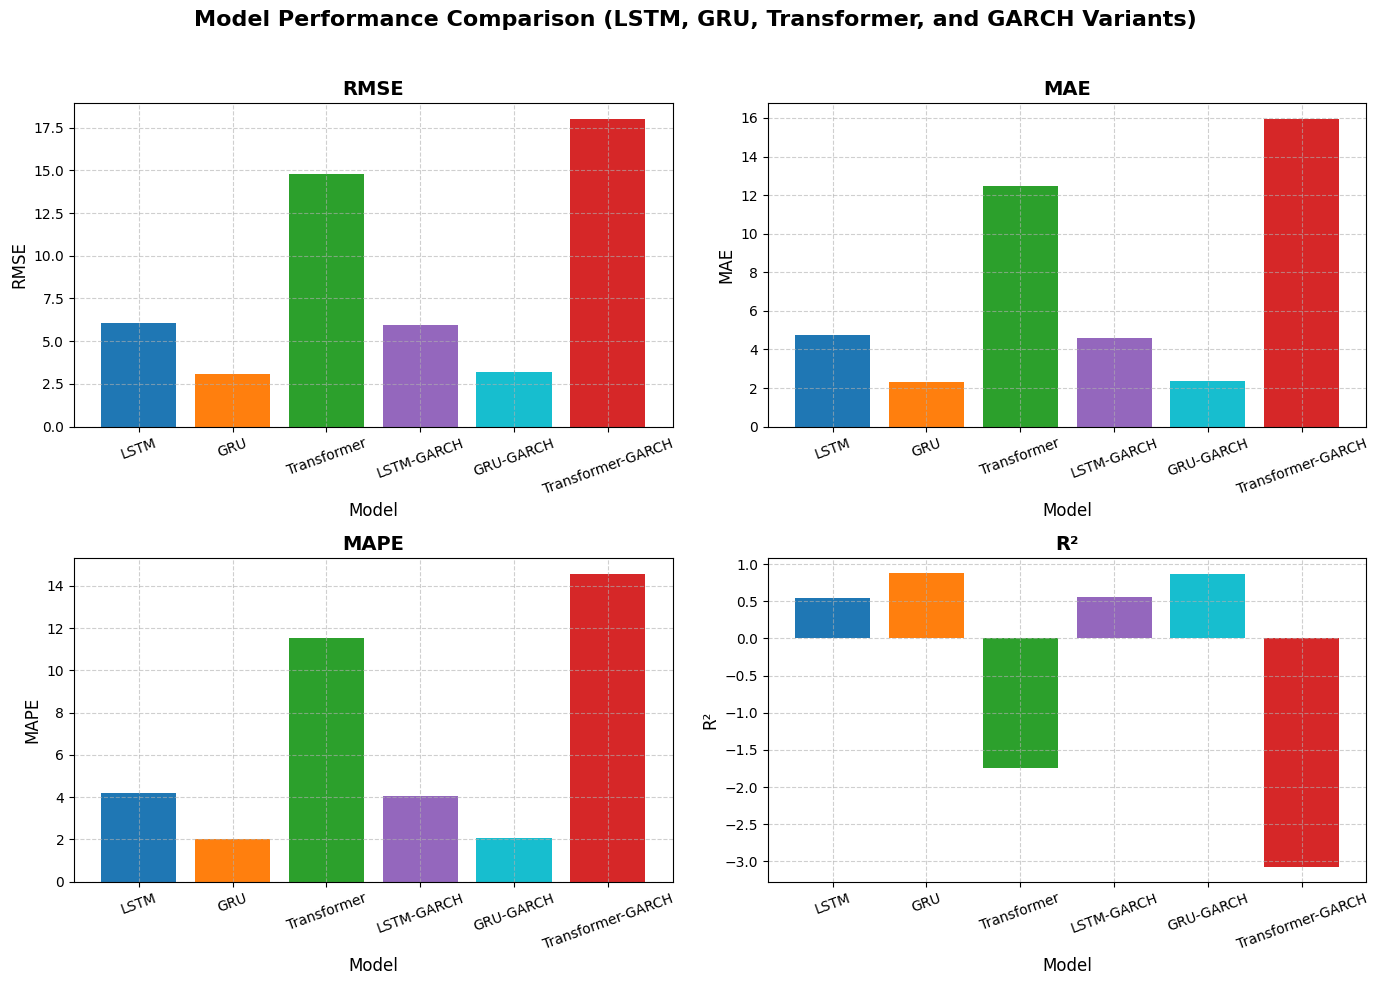

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#17becf', '#d62728']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(results_summary['Model'], results_summary[metric], color=colors)
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Model Performance Comparison (LSTM, GRU, Transformer, and GARCH Variants)",
             fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import pandas as pd

# === Base Paper Results (Constants) ===
base_results = {
    "LSTM":              {"RMSE": 3.9749, "MAE": 3.1643, "MAPE": 2.7178, "R2": 0.8079},
    "GRU":               {"RMSE": 3.4567, "MAE": 2.7625, "MAPE": 2.4354, "R2": 0.8548},
    "Transformer":       {"RMSE": 2.5303, "MAE": 1.8047, "MAPE": 1.5696, "R2": 0.9222},
    "LSTM-GARCH":        {"RMSE": 3.4567, "MAE": 2.7625, "MAPE": 2.4354, "R2": 0.8548},
    "GRU-GARCH":         {"RMSE": 0.8482, "MAE": 0.8436, "MAPE": 0.7347, "R2": 0.9913},
    "Transformer-GARCH": {"RMSE": 1.6779, "MAE": 1.6773, "MAPE": 1.4645, "R2": 0.9658}
}

observed_results = {
    "LSTM":              {"RMSE": rmse_lstm, "MAE": mae_lstm, "MAPE": mape_lstm, "R2": r2_lstm},
    "GRU":               {"RMSE": rmse_gru, "MAE": mae_gru, "MAPE": mape_gru, "R2": r2_gru},
    "Transformer":       {"RMSE": rmse_tf, "MAE": mae_tf, "MAPE": mape_tf, "R2": r2_tf},
    "LSTM-GARCH":        {"RMSE": rmse_lstm_g, "MAE": mae_lstm_g, "MAPE": mape_lstm_g, "R2": r2_lstm_g},
    "GRU-GARCH":         {"RMSE": rmse_gru_g, "MAE": mae_gru_g, "MAPE": mape_gru_g, "R2": r2_gru_g},
    "Transformer-GARCH": {"RMSE": rmse_tf_g, "MAE": mae_tf_g, "MAPE": mape_tf_g, "R2": r2_tf_g},
}

# === Compute Differences ===
diff_data = []
for model in observed_results.keys():
    diffs = {
        "Model": model,
        "ΔRMSE": observed_results[model]["RMSE"] - base_results[model]["RMSE"],
        "ΔMAE":  observed_results[model]["MAE"]  - base_results[model]["MAE"],
        "ΔMAPE": observed_results[model]["MAPE"] - base_results[model]["MAPE"],
        "ΔR²":   observed_results[model]["R2"]   - base_results[model]["R2"],
    }
    diff_data.append(diffs)

# === Display as Table ===
diff_df = pd.DataFrame(diff_data)
pd.set_option('display.precision', 4)
display(diff_df)


,Model,ΔRMSE,ΔMAE,ΔMAPE,ΔR²
0,LSTM,2.0781,1.5930,1.4563,-0.2679
1,GRU,-0.3659,-0.4548,-0.4171,0.0253
2,Transformer,12.2587,10.6891,9.9366,-2.6679
3,LSTM-GARCH,2.4719,1.8278,1.6255,-0.2960
4,GRU-GARCH,2.3321,1.5353,1.3462,-0.1183
5,Transformer-GARCH,16.3395,14.2849,13.1058,-4.0410


# **NOVELTY**

Implemented 4 new models for the same dataset; Attention based GRU, Attention based GRU with GARCH, BiDirectional GRU, BiDirectional GRU with GARCH

# **ATTENTION BASED GRU**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Attention, LayerNormalization, Permute, Multiply, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Copy master data (already ffilled)
data_gru_at = data.copy()

# Flatten columns if multi-indexed
if isinstance(data_gru_at.columns, pd.MultiIndex):
    data_gru_at.columns = data_gru_at.columns.get_level_values(0)

# Log returns (as volatility measure)
data_gru_at['LogRet'] = np.log(data_gru_at['Close']).diff()
data_gru_at = data_gru_at.dropna(subset=['Close', 'LogRet']).copy()


In [ ]:
n = len(data_gru_at)
train_size = int(n * 0.67)
train_gru_at = data_gru_at.iloc[:train_size]
test_gru_at  = data_gru_at.iloc[train_size:]


In [ ]:
# Use StandardScaler instead of MinMaxScaler
scaler_gru_at = StandardScaler()
train_scaled_gru_at = scaler_gru_at.fit_transform(train_gru_at[['Close']])
test_scaled_gru_at  = scaler_gru_at.transform(test_gru_at[['Close']])


In [ ]:
def train_gru_attention_model(lookback, train_scaled, test_scaled):
    """
    Build and train a GRU–Attention model for a given lookback window.
    Returns trained model and test sequences.
    """

    # ----- 1️⃣ Sequence creation -----
    def make_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = make_sequences(train_scaled, lookback)
    X_test, y_test = make_sequences(test_scaled, lookback)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # ----- 2️⃣ Build GRU–Attention model -----
    inputs = Input(shape=(lookback, 1))
    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = GRU(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)
    x = Multiply()([x, attention])

    x = LayerNormalization()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model_gru_at = Model(inputs, outputs)
    model_gru_at.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                         loss='mean_squared_error')

    # ----- 3️⃣ Training -----
    es = EarlyStopping(patience=5, restore_best_weights=True)
    rlr = ReduceLROnPlateau(patience=3, factor=0.5)

    history_gru_at = model_gru_at.fit(X_train, y_train,
                                      epochs=50,
                                      batch_size=32,
                                      validation_split=0.2,
                                      callbacks=[es, rlr],
                                      verbose=1)

    print(f"\n✅ Model trained successfully for lookback: {lookback} days.")

    return model_gru_at, X_test, y_test


In [ ]:
lookbacks = [30, 60, 90, 120]
models_gru_at = {}

for lb in lookbacks:
    print(f"\n================ Training for Lookback: {lb} =================")
    model_gru_at, X_test_gru_at, y_test_gru_at = train_gru_attention_model(lb, train_scaled_gru_at, test_scaled_gru_at)
    models_gru_at[lb] = {
        "model": model_gru_at,
        "X_test": X_test_gru_at,
        "y_test": y_test_gru_at
    }

    # Optionally save model for reuse
   #model_gru_at.save(f"gru_attention_{lb}.h5")



================ Training for Lookback: 30 =================
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.3611 - val_loss: 0.2765 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0600 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0547 - val_loss: 0.1116 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0457 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0454 - val_loss: 0.0990 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0412 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0389 - val_loss: 0.0893 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0338 - val_loss: 0.0716 - learning_rate: 1.0000e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━

In [ ]:
results_gru_at = []

for lb, info in models_gru_at.items():
    model = info["model"]
    X_test = info["X_test"]
    y_test = info["y_test"]

    y_pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(y_pred_scaled), 1))
    dummy[:, 0] = y_pred_scaled.ravel()
    y_pred = scaler_gru_at.inverse_transform(dummy)[:, 0]

    dummy[:, 0] = y_test
    y_true = scaler_gru_at.inverse_transform(dummy)[:, 0]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)

    print(f"\n📊 GRU–Attention Evaluation ({lb}-day lookback):")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")

    results_gru_at.append({
        "Lookback": lb,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2
    })

results_gru_at_df = pd.DataFrame(results_gru_at)
print("\nFinal GRU–Attention Results Across Lookbacks:")
print(results_gru_at_df)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

📊 GRU–Attention Evaluation (30-day lookback):
RMSE: 4.4078 | MAE: 3.4053 | MAPE: 3.01% | R²: 0.7469
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

📊 GRU–Attention Evaluation (60-day lookback):
RMSE: 9.9686 | MAE: 7.8039 | MAPE: 7.12% | R²: -0.2475
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

📊 GRU–Attention Evaluation (90-day lookback):
RMSE: 10.0386 | MAE: 8.3915 | MAPE: 7.71% | R²: -0.2157
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

📊 GRU–Attention Evaluation (120-day lookback):
RMSE: 11.5472 | MAE: 9.6527 | MAPE: 8.91% | R²: -0.5213

Final GRU–Attention Results Across Lookbacks:
   Lookback     RMSE     MAE    MAPE      R2
0        30   4.4078  3.4053  3.0105  0.7469
1        60   9.9686  7.8039  7.1245 -0.2475
2        90  10.0386  8.3915  7.7134 -0.2157
3       120  11.5472  9.6527  8.9065 -0.5213


# **GRU - Attention - GARCH**

In [ ]:
!pip install arch
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Flatten, Multiply, Permute, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Copy clean dataset
data_gru_at_garch = data.copy()

# Flatten multi-index columns if needed
if isinstance(data_gru_at_garch.columns, pd.MultiIndex):
    data_gru_at_garch.columns = data_gru_at_garch.columns.get_level_values(0)

# Compute log returns
data_gru_at_garch['LogRet'] = np.log(data_gru_at_garch['Close']).diff()
data_gru_at_garch = data_gru_at_garch.dropna(subset=['Close', 'LogRet']).copy()


In [ ]:
# Fit GARCH(1,1) on log returns
garch_model_gru_at_garch = arch_model(data_gru_at_garch['LogRet'], vol='GARCH', p=1, q=1)
res_gru_at_garch = garch_model_gru_at_garch.fit(disp='off')

# Add conditional volatility as new feature
data_gru_at_garch['GARCH_vol'] = res_gru_at_garch.conditional_volatility


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [ ]:
n = len(data_gru_at_garch)
train_size = int(n * 0.67)
train_gru_at_garch = data_gru_at_garch.iloc[:train_size]
test_gru_at_garch  = data_gru_at_garch.iloc[train_size:]


In [ ]:
scaler_gru_at_garch = StandardScaler()

train_scaled_gru_at_garch = scaler_gru_at_garch.fit_transform(train_gru_at_garch[['Close', 'GARCH_vol']])
test_scaled_gru_at_garch  = scaler_gru_at_garch.transform(test_gru_at_garch[['Close', 'GARCH_vol']])


In [ ]:
def run_gru_attention_garch(lookback, train_scaled, test_scaled, scaler):
    """
    Train and evaluate a GRU–Attention–GARCH hybrid model for a given lookback window.

    Parameters:
    -----------
    lookback : int
        Sequence length (30, 60, 90, 120)
    train_scaled : np.ndarray
        Scaled training data with Close & GARCH_vol
    test_scaled : np.ndarray
        Scaled test data with Close & GARCH_vol
    scaler : fitted StandardScaler object

    Returns:
    --------
    dict : performance metrics for the given lookback
    """

    # -----------------------------
    # 1️⃣ Create sequences
    # -----------------------------
    def make_sequences_multivariate(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i, :])  # Features: Close, GARCH_vol
            y.append(data[i, 0])             # Target: Close
        return np.array(X), np.array(y)

    X_train, y_train = make_sequences_multivariate(train_scaled, lookback)
    X_test, y_test   = make_sequences_multivariate(test_scaled, lookback)

    # -----------------------------
    # 2️⃣ Build GRU–Attention–GARCH Model
    # -----------------------------
    inputs = Input(shape=(lookback, 2))  # 2 features: Close + GARCH_vol

    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = GRU(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    # Attention block
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)
    x = Multiply()([x, attention])

    x = LayerNormalization()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error')

    # -----------------------------
    # 3️⃣ Training
    # -----------------------------
    es = EarlyStopping(patience=5, restore_best_weights=True)
    rlr = ReduceLROnPlateau(patience=3, factor=0.5)

    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[es, rlr],
                        verbose=1)

    # -----------------------------
    # 4️⃣ Prediction
    # -----------------------------
    y_pred_scaled = model.predict(X_test)

    dummy = np.zeros((len(y_pred_scaled), 2))
    dummy[:, 0] = y_pred_scaled.ravel()
    dummy[:, 1] = test_scaled[lookback:, 1]  # keep volatility alignment
    y_pred = scaler.inverse_transform(dummy)[:, 0]

    dummy_true = np.zeros_like(dummy)
    dummy_true[:, 0] = y_test
    dummy_true[:, 1] = test_scaled[lookback:, 1]
    y_true = scaler.inverse_transform(dummy_true)[:, 0]

    # -----------------------------
    # 5️⃣ Evaluation
    # -----------------------------
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)

    print(f"\n📊 GRU–Attention–GARCH ({lookback}-day Lookback)")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")

    return {
        "Lookback": lookback,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2
    }


In [ ]:
lookbacks = [30, 60, 90, 120]
results_gru_at_garch = []

for lb in lookbacks:
    print(f"\n================ Running GRU–Attention–GARCH for Lookback: {lb} =================")
    result = run_gru_attention_garch(lb, train_scaled_gru_at_garch, test_scaled_gru_at_garch, scaler_gru_at_garch)
    results_gru_at_garch.append(result)



================ Running GRU–Attention–GARCH for Lookback: 30 =================
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.4384 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0743 - val_loss: 0.1480 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0554 - val_loss: 0.0962 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0513 - val_loss: 0.1058 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0447 - val_loss: 0.1029 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0404 - val_loss: 0.1140 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0391 - val_loss: 0.0827 - learning_rate: 5.0000e-05
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0381 - val_loss: 0.0845 - learning_rate: 5.0000e-05
Epoch 9/50
29/

In [ ]:
results_gru_at_garch_df = pd.DataFrame(results_gru_at_garch)
print("\nFinal GRU–Attention–GARCH Results Across Lookbacks:")
print(results_gru_at_garch_df)


Final GRU–Attention–GARCH Results Across Lookbacks:
   Lookback     RMSE      MAE     MAPE      R2
0        30   8.7200   6.8846   6.1572  0.0095
1        60  13.6230  11.1124  10.1410 -1.3298
2        90  17.8500  15.0170  13.8629 -2.8437
3       120  17.0801  14.2970  13.2842 -2.3284


# **BiDirectional GRU**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Copy clean dataset
data_bigru = data.copy()

# Ensure column names are flat if MultiIndex
if isinstance(data_bigru.columns, pd.MultiIndex):
    data_bigru.columns = data_bigru.columns.get_level_values(0)


In [ ]:
# Create log returns to capture volatility
data_bigru['LogRet'] = np.log(data_bigru['Close']).diff()
data_bigru = data_bigru.dropna(subset=['Close', 'LogRet']).copy()

# Split into train & test (same ratio as paper)
n = len(data_bigru)
train_size = int(n * 0.67)
train_bigru = data_bigru.iloc[:train_size]
test_bigru  = data_bigru.iloc[train_size:]


In [ ]:
# Scale 'Close' prices
scaler_bigru = MinMaxScaler()
train_scaled_bigru = scaler_bigru.fit_transform(train_bigru[['Close']])
test_scaled_bigru  = scaler_bigru.transform(test_bigru[['Close']])

# Sequence generator
lookback = 60

def make_sequences(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train_bigru, y_train_bigru = make_sequences(train_scaled_bigru, lookback)
X_test_bigru, y_test_bigru   = make_sequences(test_scaled_bigru, lookback)

# Reshape [samples, timesteps, features]
X_train_bigru = X_train_bigru.reshape(X_train_bigru.shape[0], lookback, 1)
X_test_bigru  = X_test_bigru.reshape(X_test_bigru.shape[0], lookback, 1)


In [ ]:
#build model

model_bigru = Sequential([
    Bidirectional(GRU(128, return_sequences=True, input_shape=(lookback, 1))),
    Dropout(0.2),
    Bidirectional(GRU(64)),
    Dropout(0.2),
    Dense(1)
])

model_bigru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#train model

es_bigru = EarlyStopping(patience=5, restore_best_weights=True)
rlr_bigru = ReduceLROnPlateau(patience=3, factor=0.5)

history_bigru = model_bigru.fit(
    X_train_bigru, y_train_bigru,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_bigru, rlr_bigru],
    verbose=1
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - loss: 0.0866 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0081 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - loss: 0.0056 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.0044 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 0.0034 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - loss: 0.0029 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - loss: 0.0024 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - loss: 0.0022 - val_loss: 0.0043 - learning_rate: 5.0000e-05
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 0.0019 - val_loss: 0.00

In [ ]:
# Predictions
y_pred_scaled_bigru = model_bigru.predict(X_test_bigru)

# Inverse transform to original scale
dummy = np.zeros((len(y_pred_scaled_bigru), 1))
dummy[:, 0] = y_pred_scaled_bigru.ravel()
y_pred_bigru = scaler_bigru.inverse_transform(dummy)[:, 0]

dummy[:, 0] = y_test_bigru
y_true_bigru = scaler_bigru.inverse_transform(dummy)[:, 0]


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


In [ ]:
# Evaluation metrics
mse_bigru  = mean_squared_error(y_true_bigru, y_pred_bigru)
rmse_bigru = np.sqrt(mse_bigru)
mae_bigru  = mean_absolute_error(y_true_bigru, y_pred_bigru)
mape_bigru = np.mean(np.abs((y_true_bigru - y_pred_bigru) / y_true_bigru)) * 100
r2_bigru   = r2_score(y_true_bigru, y_pred_bigru)

print("\nBiGRU Results:")
print(f"RMSE: {rmse_bigru:.4f}")
print(f"MAE:  {mae_bigru:.4f}")
print(f"MAPE: {mape_bigru:.2f}%")
print(f"R²:   {r2_bigru:.4f}")


BiGRU Results:
RMSE: 6.4459
MAE:  5.2305
MAPE: 4.74%
R²:   0.4784


# **BiDIRECTIONAL GRU + GARCH**

In [ ]:
from arch import arch_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ Copy dataset
data_bigru_g = data.copy()

# Flatten MultiIndex if needed
if isinstance(data_bigru_g.columns, pd.MultiIndex):
    data_bigru_g.columns = data_bigru_g.columns.get_level_values(0)


In [ ]:
# Calculate log returns
data_bigru_g['LogRet'] = np.log(data_bigru_g['Close']).diff()
data_bigru_g = data_bigru_g.dropna(subset=['Close', 'LogRet']).copy()

# Fit GARCH(1,1) model on training log returns
n = len(data_bigru_g)
train_size = int(n * 0.67)
train_bigru_g = data_bigru_g.iloc[:train_size].copy()
test_bigru_g  = data_bigru_g.iloc[train_size:].copy()

# Fit GARCH on training log returns
garch_model_bigru_g = arch_model(train_bigru_g['LogRet'], vol='GARCH', p=1, q=1)
res_bigru_g = garch_model_bigru_g.fit(disp='off')

# Add conditional volatility (σt) to dataset
data_bigru_g['GARCH_vol'] = res_bigru_g.conditional_volatility
data_bigru_g = data_bigru_g.dropna(subset=['GARCH_vol']).copy()


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [ ]:
n = len(data_bigru_g)
train_size = int(n * 0.67)

train_bigru_g = data_bigru_g.iloc[:train_size]
test_bigru_g  = data_bigru_g.iloc[train_size:]

# Scale both Close & GARCH_vol
scaler_bigru_g = MinMaxScaler()
train_scaled_bigru_g = scaler_bigru_g.fit_transform(train_bigru_g[['Close', 'GARCH_vol']])
test_scaled_bigru_g  = scaler_bigru_g.transform(test_bigru_g[['Close', 'GARCH_vol']])


In [ ]:
lookback = 60

def make_sequences_multivariate(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, :])  # features: Close + GARCH_vol
        y.append(dataset[i, 0])             # target: Close
    return np.array(X), np.array(y)

X_train_bigru_g, y_train_bigru_g = make_sequences_multivariate(train_scaled_bigru_g, lookback)
X_test_bigru_g,  y_test_bigru_g  = make_sequences_multivariate(test_scaled_bigru_g, lookback)


In [ ]:
#build model

model_bigru_g = Sequential([
    Bidirectional(GRU(128, return_sequences=True, input_shape=(lookback, 2))),
    Dropout(0.2),
    Bidirectional(GRU(64)),
    Dropout(0.2),
    Dense(1)
])

model_bigru_g.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#train model

es_bigru_g = EarlyStopping(patience=5, restore_best_weights=True)
rlr_bigru_g = ReduceLROnPlateau(patience=3, factor=0.5)

history_bigru_g = model_bigru_g.fit(
    X_train_bigru_g, y_train_bigru_g,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es_bigru_g, rlr_bigru_g],
    verbose=1
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - loss: 0.1764 - val_loss: 0.0283 - learning_rate: 1.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.0166 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0149 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - loss: 0.0103 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - loss: 0.0089 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 0.0084 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - loss: 0.0077 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 0.0072 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - loss: 0.0069 - val_loss: 0.0016 -

In [ ]:
# Predictions
y_pred_scaled_bigru_g = model_bigru_g.predict(X_test_bigru_g)

# Inverse transform
dummy = np.zeros((len(y_pred_scaled_bigru_g), 2))
dummy[:, 0] = y_pred_scaled_bigru_g.ravel()
dummy[:, 1] = test_scaled_bigru_g[lookback:, 1]

y_pred_bigru_g = scaler_bigru_g.inverse_transform(dummy)[:, 0]

dummy_true = np.zeros_like(dummy)
dummy_true[:, 0] = y_test_bigru_g
dummy_true[:, 1] = test_scaled_bigru_g[lookback:, 1]
y_true_bigru_g = scaler_bigru_g.inverse_transform(dummy_true)[:, 0]


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step


In [ ]:
# Evaluate Metrics
mse_bigru_g  = mean_squared_error(y_true_bigru_g, y_pred_bigru_g)
rmse_bigru_g = np.sqrt(mse_bigru_g)
mae_bigru_g  = mean_absolute_error(y_true_bigru_g, y_pred_bigru_g)
mape_bigru_g = np.mean(np.abs((y_true_bigru_g - y_pred_bigru_g) / y_true_bigru_g)) * 100
r2_bigru_g   = r2_score(y_true_bigru_g, y_pred_bigru_g)

print("\nBiGRU–GARCH Results:")
print(f"RMSE: {rmse_bigru_g:.4f}")
print(f"MAE:  {mae_bigru_g:.4f}")
print(f"MAPE: {mape_bigru_g:.2f}%")
print(f"R²:   {r2_bigru_g:.4f}")


BiGRU–GARCH Results:
RMSE: 7.6348
MAE:  6.6250
MAPE: 4.64%
R²:   0.4714


# **CONCLUSION - 10 MODELS**

In [ ]:
import pandas as pd

# Find the best GRU-Attention model based on RMSE
best_gru_at_result = results_gru_at_df.loc[results_gru_at_df['RMSE'].idxmin()]

# Find the GRU-Attention-GARCH model with 30-day lookback (based on the error)
gru_at_garch_30_result = results_gru_at_garch_df.loc[results_gru_at_garch_df['Lookback'] == 30].iloc[0]


# ✅ Store all model metrics in a dictionary
results_all = {
    "Model": [
        "LSTM",
        "GRU",
        "Transformer",
        "LSTM–GARCH",
        "GRU–GARCH",
        "Transformer–GARCH",
        f"GRU–Attention ({int(best_gru_at_result['Lookback'])})",
        f"GRU–Attention–GARCH ({int(gru_at_garch_30_result['Lookback'])})",
        "BiGRU",
        "BiGRU–GARCH"
    ],
    "RMSE": [
        rmse_lstm,
        rmse_gru,
        rmse_tf,
        rmse_lstm_g,
        rmse_gru_g,
        rmse_tf_g,
        best_gru_at_result['RMSE'],
        gru_at_garch_30_result['RMSE'],
        rmse_bigru,
        rmse_bigru_g
    ],
    "MAE": [
        mae_lstm,
        mae_gru,
        mae_tf,
        mae_lstm_g,
        mae_gru_g,
        mae_tf_g,
        best_gru_at_result['MAE'],
        gru_at_garch_30_result['MAE'],
        mae_bigru,
        mae_bigru_g
    ],
    "MAPE": [
        mape_lstm,
        mape_gru,
        mape_tf,
        mape_lstm_g,
        mape_gru_g,
        mape_tf_g,
        best_gru_at_result['MAPE'],
        gru_at_garch_30_result['MAPE'],
        mape_bigru,
        mape_bigru_g
    ],
    "R²": [
        r2_lstm,
        r2_gru,
        r2_tf,
        r2_lstm_g,
        r2_gru_g,
        r2_tf_g,
        best_gru_at_result['R2'],
        gru_at_garch_30_result['R2'],
        r2_bigru,
        r2_bigru_g
    ]
}

# ✅ Create DataFrame
df_results_all = pd.DataFrame(results_all)

# ✅ Sort by RMSE (optional)
df_results_all = df_results_all.sort_values(by="R²", ascending=True).reset_index(drop=True)

# ✅ Display neatly
print("\n📊 Final Model Performance Summary Across All 10 Models:\n")
print(df_results_all.round(4))

# ✅ Optional: export to CSV for report use
#df_results_all.to_csv("Final_Model_Comparison.csv", index=False)
#print("\n✅ Results saved to 'Final_Model_Comparison.csv'")



📊 Final Model Performance Summary Across All 10 Models:

                      Model     RMSE      MAE     MAPE      R²
0         Transformer–GARCH  18.0174  15.9622  14.5703 -3.0752
1               Transformer  14.7890  12.4938  11.5062 -1.7457
2  GRU–Attention–GARCH (30)   8.7200   6.8846   6.1572  0.0095
3               BiGRU–GARCH   7.6348   6.6250   4.6389  0.4714
4                     BiGRU   6.4459   5.2305   4.7397  0.4784
5                      LSTM   6.0530   4.7573   4.1741  0.5400
6                LSTM–GARCH   5.9286   4.5903   4.0609  0.5588
7        GRU–Attention (30)   4.4078   3.4053   3.0105  0.7469
8                 GRU–GARCH   3.1803   2.3789   2.0809  0.8730
9                       GRU   3.0908   2.3077   2.0183  0.8801
